In [1]:
%matplotlib inline
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

# --- ATLAS style ---
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasUtils.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasLabels.C")
ROOT.SetAtlasStyle()

ROOT.EnableImplicitMT()

# --- Load Delphes ---
delphes_dir = "/home/kalelc/research/Delphes-3.5.0/"
status = ROOT.gSystem.Load(delphes_dir + "libDelphes.so")
if status != 0:
    raise RuntimeError("Error: Could not load libDelphes.so")
print("libDelphes.so loaded successfully!")

# Input ROOT file
fdisplaced_dark = delphes_dir + "displacedPhoton/dark_events.root"
fdisplaced_half = delphes_dir + "displacedPhoton/displaced_half_dark_events.root"
fprompt_half = delphes_dir + "displacedPhoton/prompt_half_dark_events.root"
fprompt_non_dark = delphes_dir + "displacedPhoton/non_dark_events.root"
df_displaced_dark = ROOT.RDataFrame("Delphes", fdisplaced_dark)
df_displaced_half = ROOT.RDataFrame("Delphes", fdisplaced_half)
df_prompt_half = ROOT.RDataFrame("Delphes", fprompt_half)
df_prompt_non_dark = ROOT.RDataFrame("Delphes", fprompt_non_dark)


Applying ATLAS style settings...

libDelphes.so loaded successfully!


In [2]:
def create_missingET_dataframe(root_file_path):
    # Load the ROOT file into an RDataFrame
    rdf = ROOT.RDataFrame("Delphes", root_file_path)
    
    # Convert the specified properties to a dictionary of numpy arrays
    missingET_dict = rdf.AsNumpy([
        "Event.Number",
        "MissingET.MET",
        "MissingET.Eta",
        "MissingET.Phi",
        "GenMissingET.MET",
        "GenMissingET.Eta",
        "GenMissingET.Phi",
    ])
    
    # Flatten event numbers (scalars, not 1-element arrays)
    event_numbers = [arr[0] for arr in missingET_dict["Event.Number"]]
    
    # Build the DataFrame
    missingET_df = pd.DataFrame({
        "EventNumber": event_numbers,
        "MissingET_MET": missingET_dict["MissingET.MET"],
        "MissingET_Eta": missingET_dict["MissingET.Eta"],
        "MissingET_Phi": missingET_dict["MissingET.Phi"],
        "GenMissingET_MET": missingET_dict["GenMissingET.MET"],
        "GenMissingET_Eta": missingET_dict["GenMissingET.Eta"],
        "GenMissingET_Phi": missingET_dict["GenMissingET.Phi"],
    })
    
    # Explode so each entry gets its own row
    missingET_df = missingET_df.explode(
        ["MissingET_MET", "MissingET_Eta", "MissingET_Phi", 
         "GenMissingET_MET", "GenMissingET_Eta", "GenMissingET_Phi"], 
        ignore_index=True
    )

    # Sort by EventNumber and reset the index
    missingET_df = missingET_df.sort_values(by="EventNumber").reset_index(drop=True)
    
    return missingET_df

In [3]:
displaced_dark_df = create_missingET_dataframe(fdisplaced_dark)
displaced_half_df = create_missingET_dataframe(fdisplaced_half)
prompt_half_df = create_missingET_dataframe(fprompt_half)
prompt_non_dark_df = create_missingET_dataframe(fprompt_non_dark)
displaced_dark_df

,EventNumber,MissingET_MET,MissingET_Eta,MissingET_Phi,GenMissingET_MET,GenMissingET_Eta,GenMissingET_Phi
0,0,16.621162,2.683642,-1.200758,65.756493,1.192587,-0.913688
1,1,17.432323,2.365368,-1.338993,29.189962,3.352497,-2.816309
2,2,36.618279,1.812678,2.605128,40.324047,3.18961,2.954522
3,3,52.176125,1.541661,-0.002952,55.542053,2.932591,-0.242607
4,4,32.664673,-3.437068,-1.563951,30.059149,-0.962189,-1.76334
...,...,...,...,...,...,...,...
3995,3995,407.082581,-1.770939,2.593266,455.278961,-1.149549,2.604759
3996,3996,26.90897,3.715106,-2.376417,41.253624,3.30904,-2.541027
3997,3997,32.670761,3.918763,0.534935,24.704882,4.203326,0.144974
3998,3998,47.516613,2.945565,1.126658,65.420845,2.676463,1.389274


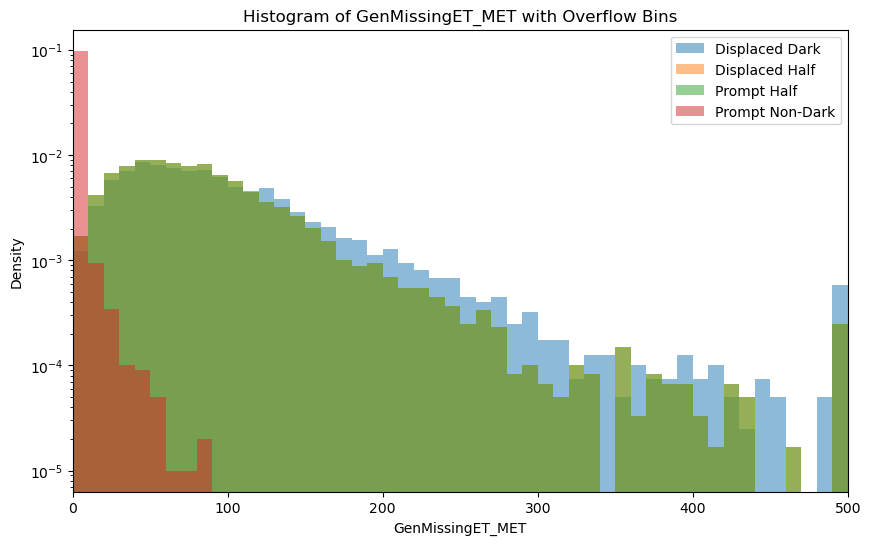

In [4]:
# Plot histograms of GenMissingET_MET for each dataset with overflow bins and xlim
plt.figure(figsize=(10, 6))

# Define bins with an overflow bin
bins = np.linspace(0, 500, 51)  # 50 bins from 0 to 500

# Plot histograms
plt.hist(np.clip(displaced_dark_df["GenMissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Displaced Dark", density=True)
plt.hist(np.clip(displaced_half_df["GenMissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Displaced Half", density=True)
plt.hist(np.clip(prompt_half_df["GenMissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Prompt Half", density=True)
plt.hist(np.clip(prompt_non_dark_df["GenMissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Prompt Non-Dark", density=True)

# Add labels, legend, and set xlim
plt.xlabel("GenMissingET_MET")
plt.ylabel("Density")
plt.yscale('log')
plt.xlim(0, 500)
plt.title("Histogram of GenMissingET_MET with Overflow Bins")
plt.legend()
plt.show()

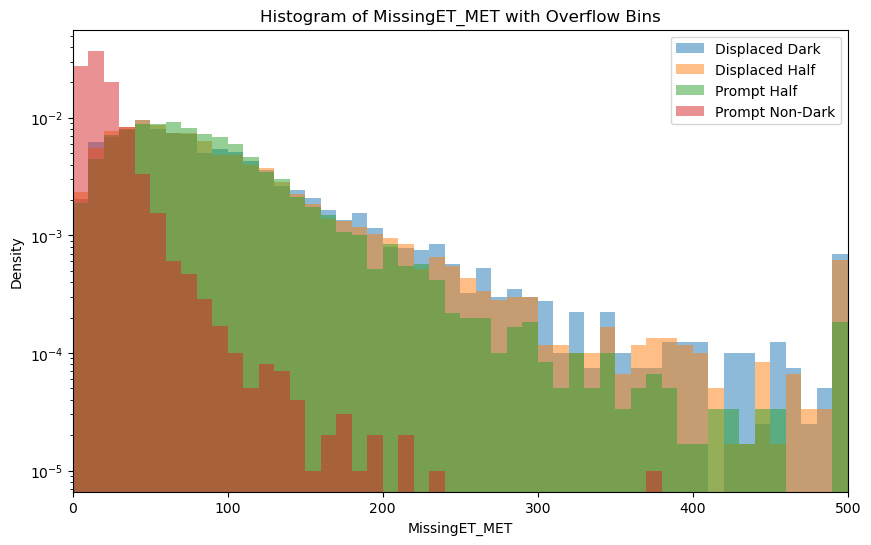

In [5]:
# Plot histograms of MissingET_MET for each dataset with overflow bins and xlim
plt.figure(figsize=(10, 6))

# Define bins with an overflow bin
bins = np.linspace(0, 500, 51)  # 50 bins from 0 to 500

# Plot histograms
plt.hist(np.clip(displaced_dark_df["MissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Displaced Dark", density=True)
plt.hist(np.clip(displaced_half_df["MissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Displaced Half", density=True)
plt.hist(np.clip(prompt_half_df["MissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Prompt Half", density=True)
plt.hist(np.clip(prompt_non_dark_df["MissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Prompt Non-Dark", density=True)

# Add labels, legend, and set xlim
plt.xlabel("MissingET_MET")
plt.ylabel("Density")
plt.yscale('log')
plt.xlim(0, 500)
plt.title("Histogram of MissingET_MET with Overflow Bins")
plt.legend()
plt.show()

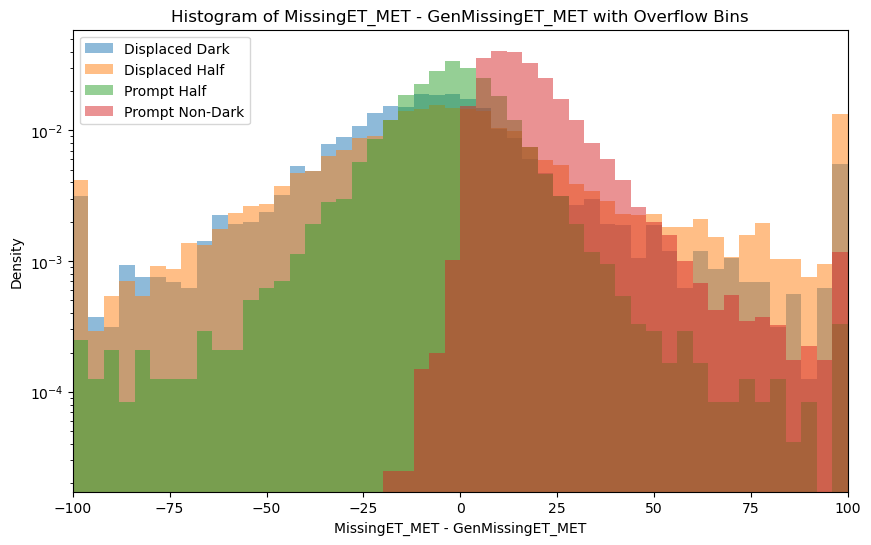

In [6]:
# Plot histograms of MissingET_MET - GenMissingET_MET for each dataset with overflow bins and xlim
plt.figure(figsize=(10, 6))

# Define bins with an x-range of -100 to 100
bins = np.linspace(-100, 100, 51)  # 50 bins from -100 to 100

# Plot histograms
plt.hist(
    np.clip(
        displaced_dark_df["MissingET_MET"].astype(float) - displaced_dark_df["GenMissingET_MET"].astype(float),
        bins[0], bins[-1]
    ),
    bins=bins, alpha=0.5, label="Displaced Dark", density=True
)
plt.hist(
    np.clip(
        displaced_half_df["MissingET_MET"].astype(float) - displaced_half_df["GenMissingET_MET"].astype(float),
        bins[0], bins[-1]
    ),
    bins=bins, alpha=0.5, label="Displaced Half", density=True
)
plt.hist(
    np.clip(
        prompt_half_df["MissingET_MET"].astype(float) - prompt_half_df["GenMissingET_MET"].astype(float),
        bins[0], bins[-1]
    ),
    bins=bins, alpha=0.5, label="Prompt Half", density=True
)
plt.hist(
    np.clip(
        prompt_non_dark_df["MissingET_MET"].astype(float) - prompt_non_dark_df["GenMissingET_MET"].astype(float),
        bins[0], bins[-1]
    ),
    bins=bins, alpha=0.5, label="Prompt Non-Dark", density=True
)

# Add labels, legend, and set xlim
plt.xlabel("MissingET_MET - GenMissingET_MET")
plt.ylabel("Density")
plt.yscale('log')
plt.xlim(-100, 100)
plt.title("Histogram of MissingET_MET - GenMissingET_MET with Overflow Bins")
plt.legend()
plt.show()

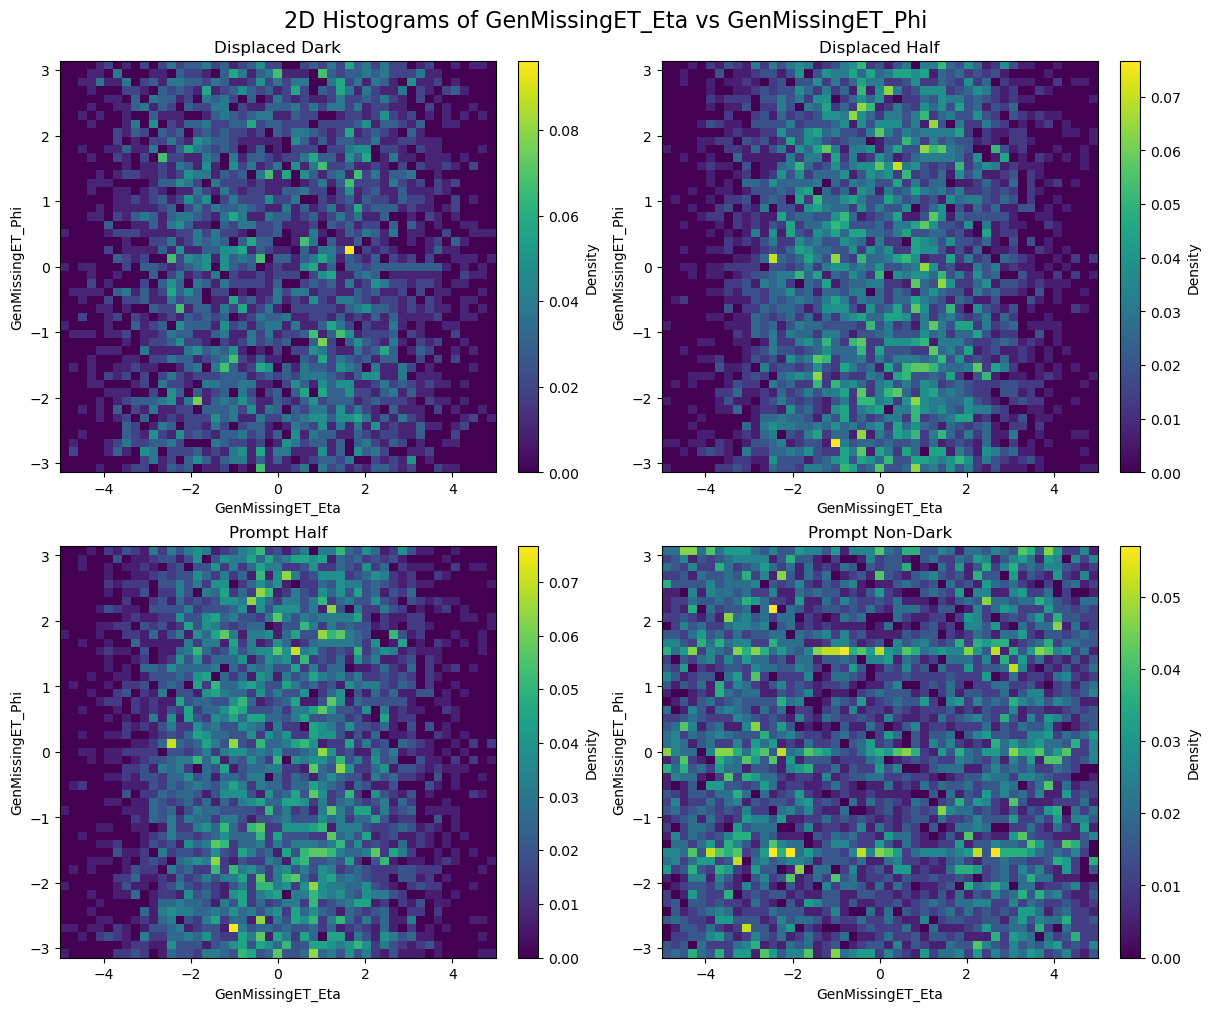

In [7]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# Define the datasets and titles
datasets = [
    (displaced_dark_df, "Displaced Dark"),
    (displaced_half_df, "Displaced Half"),
    (prompt_half_df, "Prompt Half"),
    (prompt_non_dark_df, "Prompt Non-Dark"),
]

# Define the bin edges for eta and phi
eta_bins = np.linspace(-5, 5, 50)
phi_bins = np.linspace(-np.pi, np.pi, 50)

# Loop through datasets and plot 2D histograms
for ax, (df, title) in zip(axes.flatten(), datasets):
    h, xedges, yedges, img = ax.hist2d(
        df["GenMissingET_Eta"].astype(float),
        df["GenMissingET_Phi"].astype(float),
        bins=[eta_bins, phi_bins],
        density=True,
        cmap="viridis",
    )
    ax.set_title(title)
    ax.set_xlabel("GenMissingET_Eta")
    ax.set_ylabel("GenMissingET_Phi")
    fig.colorbar(img, ax=ax, label="Density")

# Show the plot
plt.suptitle("2D Histograms of GenMissingET_Eta vs GenMissingET_Phi", fontsize=16)
plt.show()

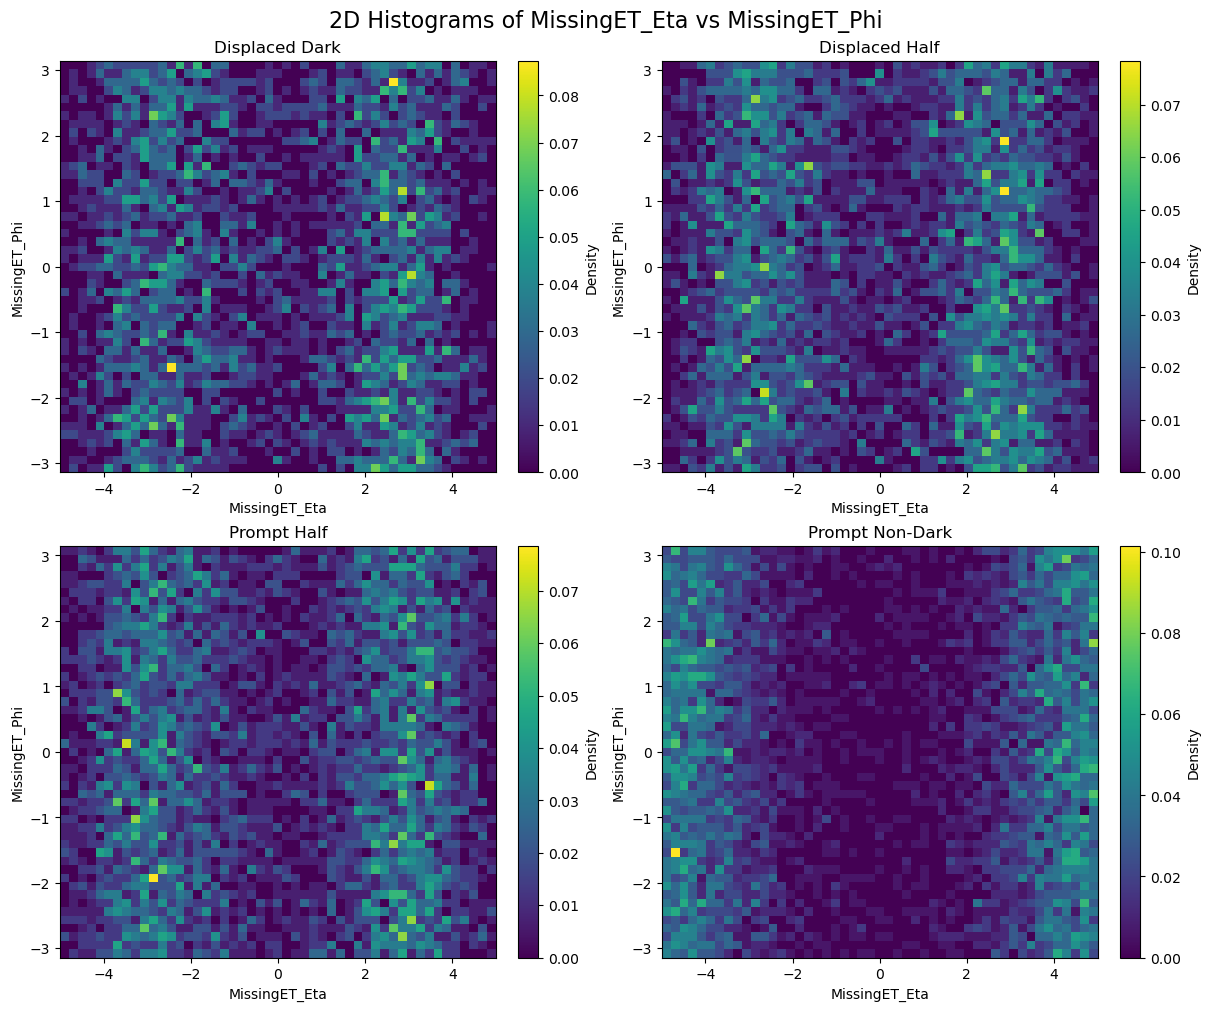

In [8]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# Define the datasets and titles
datasets = [
    (displaced_dark_df, "Displaced Dark"),
    (displaced_half_df, "Displaced Half"),
    (prompt_half_df, "Prompt Half"),
    (prompt_non_dark_df, "Prompt Non-Dark"),
]

# Define the bin edges for eta and phi
eta_bins = np.linspace(-5, 5, 50)
phi_bins = np.linspace(-np.pi, np.pi, 50)

# Loop through datasets and plot 2D histograms
for ax, (df, title) in zip(axes.flatten(), datasets):
    h, xedges, yedges, img = ax.hist2d(
        df["MissingET_Eta"].astype(float),
        df["MissingET_Phi"].astype(float),
        bins=[eta_bins, phi_bins],
        density=True,
        cmap="viridis",
    )
    ax.set_title(title)
    ax.set_xlabel("MissingET_Eta")
    ax.set_ylabel("MissingET_Phi")
    fig.colorbar(img, ax=ax, label="Density")

# Show the plot
plt.suptitle("2D Histograms of MissingET_Eta vs MissingET_Phi", fontsize=16)
plt.show()

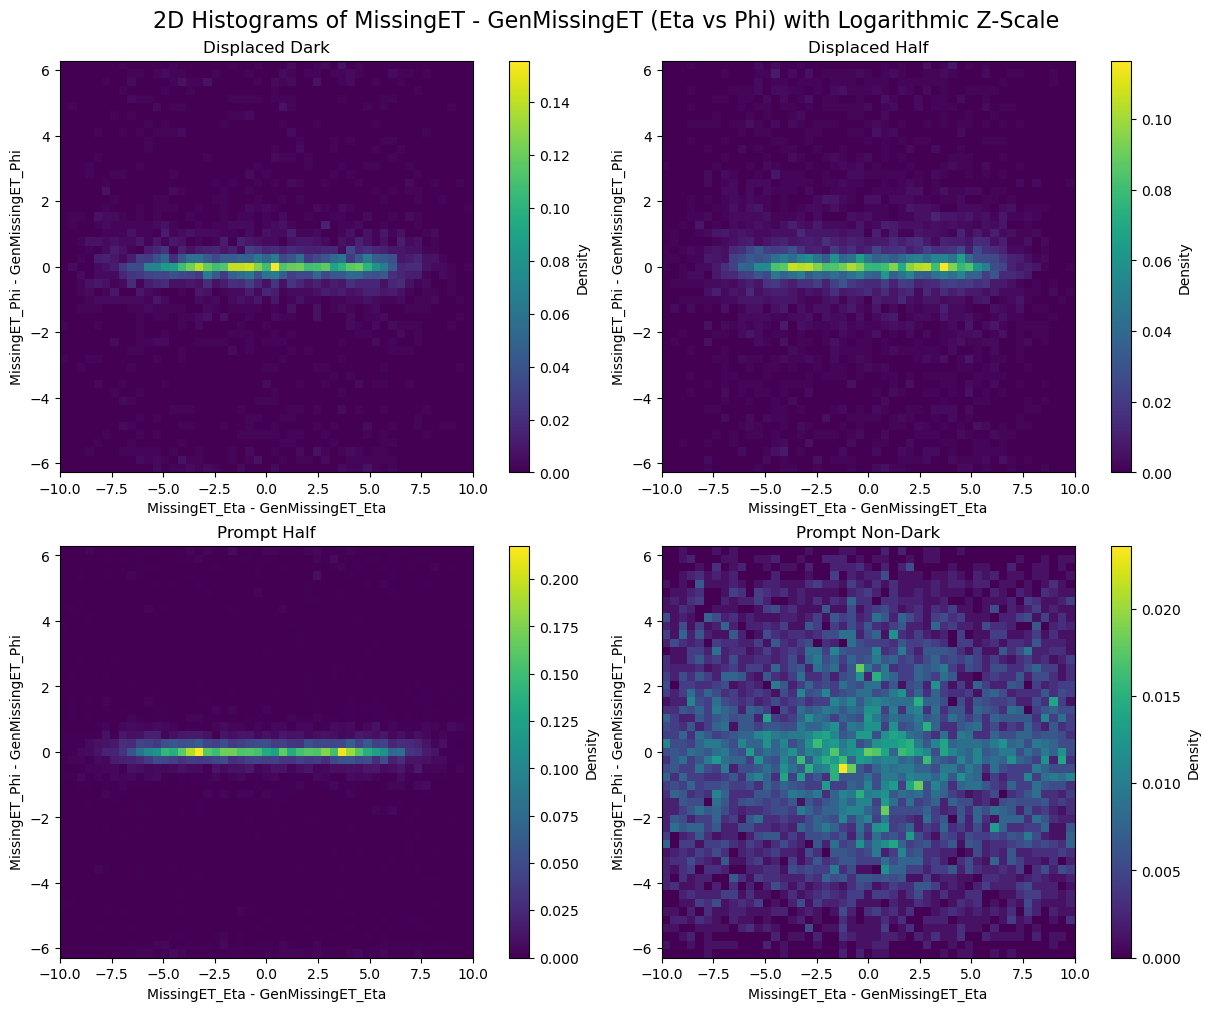

In [9]:
from matplotlib.colors import LogNorm

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# Define the datasets and titles
datasets = [
    (displaced_dark_df, "Displaced Dark"),
    (displaced_half_df, "Displaced Half"),
    (prompt_half_df, "Prompt Half"),
    (prompt_non_dark_df, "Prompt Non-Dark"),
]

# Define the bin edges for eta and phi differences
eta_diff_bins = np.linspace(-10, 10, 50)
phi_diff_bins = np.linspace(-2 * np.pi, 2 * np.pi, 50)

# Loop through datasets and plot 2D histograms
for ax, (df, title) in zip(axes.flatten(), datasets):
    h, xedges, yedges, img = ax.hist2d(
        df["MissingET_Eta"].astype(float) - df["GenMissingET_Eta"].astype(float),
        df["MissingET_Phi"].astype(float) - df["GenMissingET_Phi"].astype(float),
        bins=[eta_diff_bins, phi_diff_bins],
        density=True,
        cmap="viridis",
        # norm=LogNorm(),  # Set logarithmic scale for z-space
    )
    ax.set_title(title)
    ax.set_xlabel("MissingET_Eta - GenMissingET_Eta")
    ax.set_ylabel("MissingET_Phi - GenMissingET_Phi")
    fig.colorbar(img, ax=ax, label="Density")

# Show the plot
plt.suptitle("2D Histograms of MissingET - GenMissingET (Eta vs Phi) with Logarithmic Z-Scale", fontsize=16)
plt.show()